### Using Pandas together with SQL

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
# Install the SQLAlchemy library if it is not installed
# !sudo -H pip3 install -U sqlalchemy

In [4]:
from sqlalchemy import create_engine

### Importing into DataFrames using read_sql

The `read_sql` function of Pandas allows us to create a dataframe directly from a SQL query. To execute the query, we first setup the connection to the database using the SQLAlchemy library.

In [5]:
conn_string_imdb = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='imdb',
    encoding = 'utf-8'
)
engine_imdb = create_engine(conn_string_imdb)

#### Retrieve the first 10 lines from the actors table 

Let's start with a simple example. We issue an SQL query, and get back the results loaded in a dataframe.

In [ ]:
query = '''
SELECT * FROM actors LIMIT 10
'''

In [ ]:
df_actors = pd.read_sql(query, con=engine_imdb)

In [ ]:
df_actors

#### Retrieve the number of movies per year

Now let's work on a slightly more advanced example. We want to analyze the number of movies over time.

In [ ]:
query = '''
SELECT year, COUNT(*) AS num_movies, COUNT(rank) AS rated_movies
FROM movies 
GROUP BY year
ORDER BY year
'''

In [ ]:
df_movies = pd.read_sql(query, con=engine_imdb)

In [ ]:
df_movies

Let's try to plot the results. In pandas, the simple `plot()` command will use the index as the x-axis, and will plot all the numeric columns, as a line plot.

In [ ]:
# The plot() command takes the index (the first "column") of the dataframe
# and makes that the x-axis.
# Then it plots *ALL* the numeric columns as a line
df_movies.plot()

We do not want to plot the `year` variable as a line. So, we select just the other two columns and plot.

In [ ]:
# First step: We can eliminate the "year" line by selecting 
# the columns that we want to plot
# To select columns, we pass a list of the column names that
# we want to keep in square brackets
df_movies[ ["num_movies", "rated_movies"] ].plot() 
# still the x-axis does not list the year

We have a couple of issues. We also plotted the year as a line, and we do not have it as the label of the x-axis. For that, we need to convert the year into a proper datetime variable, and then make it the index for the dataframe.

In [ ]:
# We are going to make the "year" column to be the index

# We first convert the column into the right datatype (datetime)
df_movies['year'] = pd.to_datetime(df_movies['year'], format='%Y')
# And now we specify that the (converted) year column should be the index
# The set_index command does not modify the dataframe itself, but rather
# it returns a new dataframe with the new index. That's why we save the 
# result in df_movies2
df_movies2 = df_movies.set_index('year')
df_movies2

In [ ]:
df_movies2.plot()

### Exercise

* Connect to the Facebook database, and use the `MemberSince` variable from the `Profiles` table to plot the growth of Facebook users. Use the following information:
>    user='student', 
>    password='dwdstudent2015', 
>    host = 'db.ipeirotis.org', 
>    port=3306, 
>    db='facebook'
* (_Learn something new_) Use the [cumsum()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.cumsum.html) function of Pandas and plot the total number of registered users over time.

### Further Examples with SQL and Pandas

Now let's run a query to get the political views of Facebook users, broken down by gender.

In [6]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='facebook'
)
engine_fb = create_engine(conn_string_fb)

In [ ]:
polviews_by_gender = '''
SELECT Sex, PoliticalViews, COUNT(*) AS cnt 
FROM Profiles 
WHERE Sex IS NOT NULL AND PoliticalViews IS NOT NULL 
GROUP BY Sex, PoliticalViews
ORDER BY  PoliticalViews, Sex
'''

And let's get the dataframe:

In [ ]:
df = pd.read_sql(polviews_by_gender, con=engine_fb)
df

In [ ]:
df.dtypes

We will now convert the PoliticalViews column into an ordered Categorical variable. This is not strictly necessary, but it will be useful later.
 It ensures that Political Views appear in an order according to their political spectrum, as opposed to alphabetical.

In [ ]:
# This is not strictly necessary, but it will be useful later.
# It ensures that Political Views appear in an order according to their
# political spectrum, as opposed to alphabetical
df["PoliticalViews"] =  pd.Categorical(df["PoliticalViews"], 
                            categories = ['Very Liberal', 'Liberal', 'Moderate', 'Conservative', 'Very Conservative', 'Libertarian', 'Apathetic', 'Other'], 
                            ordered=True)


In [ ]:
# Let's plot this!
# Bleh, this is really fugly...
# Remember that the index of the dataframe becomes the default x-axis
df.plot(kind='bar')

In [ ]:
# Pivot, baby!
# Now the index contains the Political Views, which will be our x-axis
dfp = df.pivot_table(index='PoliticalViews', columns='Sex', values='cnt')
dfp

In [ ]:
dfp.plot(kind='bar')

#### Normalizing values in Pandas

Now, let's see a bit how we can normalize the values in Pandas, by performing operations on the columns and rows.

In [ ]:
dfp

In [ ]:
dfp.sum() # sums across the rows

In [ ]:
dfp.sum(axis='index') # sums across the rows (equivalent to dfp.sum() and dfp.sum(axis=0) )

In [ ]:
dfp.sum(axis='columns') # this one sums across the columns (axis=1)

In [ ]:
# Let's normalize the columns, as we have more females than males, and it seems that there are always more women
dfp_norm = dfp / dfp.sum()
dfp_norm

In [ ]:
# Instead of dfp / dfp.sum(), we can also use the .div() method, for dividing the entries with the sum()
# Note that, by definition, the dfp / dfp.sum() operation divides  column-wise, not row-wise.
dfp_norm = dfp.div( dfp.sum(), axis='columns' )
dfp_norm

In [ ]:
dfp

In [ ]:
# And now let's do the division by normalizing the values row-wise,
# to find the fraction of males/females within each political category
dfp_norm2 = dfp.div( dfp.sum(axis='columns'), axis='index' )
dfp_norm2

In [ ]:
dfp_norm.plot(kind='bar')

In [ ]:
dfp_norm2.plot(kind='bar')

#### Exercise

a. Use the tables `RelationshipStatus` and `LookingFor`, and show create a plot with a breakdown of what people in different relationship statuses are looking for. To make things more readable (and to practice a bit SQL), remove from the output all combinations that have less than 10 students in them. The plot can use the absolute counts.

b. Normalize the results and plot again. To get experience with normalization, try to normalize both by Status (eg "80% of the people who are in a relationship are looking for Friendship") and by Relationship Status (eg "70% of the people who are looking for Random Play are Single"). 

### Facebook, Favorite Books, and Political views

Now let's do an analysis that examines book preferences and how they correlated with political leanings.

We will start by fetching the favorite books for students that declared themselves as Liberal or Conservative.

In [77]:
books = '''
SELECT B.Book, P.PoliticalViews, COUNT(*) AS cnt 
FROM Profiles P JOIN FavoriteBooks B ON B.ProfileID = P.ProfileId  
WHERE PoliticalViews IS NOT NULL AND B.Book IS NOT NULL 
      AND (PoliticalViews = 'Liberal' OR PoliticalViews = 'Conservative')
GROUP BY B.Book, P.PoliticalViews
HAVING cnt > 5
'''

In [78]:
df_books = pd.read_sql(books, con=engine_fb)
df_books.head(10)

,Book,PoliticalViews,cnt
0,100 Years Of Solitude,Liberal,55
1,1984,Conservative,32
2,1984,Liberal,286
3,1984 Orwell,Liberal,6
4,5 People You Meet In Heaven,Liberal,7
5,A Brave New World,Liberal,7
6,A Brief History Of Time,Liberal,7
7,A Clockwork Orange,Conservative,8
8,A Clockwork Orange,Liberal,86
9,A Confederacy Of Dunces,Liberal,37


In [90]:
dfp = df_books.pivot_table(index='Book', columns='PoliticalViews', values='cnt')
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
100 Years Of Solitude,NaN,55.0
1984,32.0,286.0
1984 Orwell,NaN,6.0
5 People You Meet In Heaven,NaN,7.0
A Brave New World,NaN,7.0
A Brief History Of Time,NaN,7.0
A Clockwork Orange,8.0,86.0
A Confederacy Of Dunces,NaN,37.0
A Doll S House,NaN,12.0


Notice the `NaN` values for the entries where we had no users falling into that group. Since we will want to do calculations for these books as well, we will use the `fillna` command to fill these entries with a default value (in our case, 0)

In [92]:
# Fill the NaN entries with the value 0 
dfp = df_books.pivot_table(index='Book', columns='PoliticalViews', values='cnt').fillna(0)
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
100 Years Of Solitude,0.0,55.0
1984,32.0,286.0
1984 Orwell,0.0,6.0
5 People You Meet In Heaven,0.0,7.0
A Brave New World,0.0,7.0
A Brief History Of Time,0.0,7.0
A Clockwork Orange,8.0,86.0
A Confederacy Of Dunces,0.0,37.0
A Doll S House,0.0,12.0


**Normalization**: We now want to normalize the entries before proceeding further. Let's take a look at the breakdown of political views in the database.

In [93]:
polviews = '''
SELECT PoliticalViews, COUNT(*) AS cnt 
FROM facebook.Profiles
GROUP BY PoliticalViews
'''

In [94]:
df_polviews = pd.read_sql(polviews, con=engine_fb)
df_polviews

,PoliticalViews,cnt
0,None,11091
1,Apathetic,805
2,Conservative,936
3,Liberal,6461
4,Libertarian,325
5,Moderate,2898
6,Other,824
7,Very Conservative,167
8,Very Liberal,2277


Since we have many more conservatives than liberals, let's create a new column that calculates the **percentage** of liberal and conservative students that liked each book. For simplicity, we just enter directly the values 6461 (number of liberals) and 936 (number of conservatives). We add the `+1` in the numerator to avoid division by zero later on. _As practice, try to fetch the values 936 and 6461 directly from the database, and automate the calculation._

In [95]:
dfp["Liberal_perc"] = (dfp["Liberal"] +1)  / 6461
dfp["Conservative_perc"] = (dfp["Conservative"] +1)  / 936

#### Lift

Now that we have the normalized values, we can compute the **lift** for each book. The lift is the ratio between the percentage of liberals and the percentage of convervatives. A book with `lift==1` will be equally read by both conservatives and liberals. Books that have lifts significantly higher or lower than 1, reveal preferences to be read by one side of the political spectrum.

In [96]:
dfp["lift_liberal"] = dfp["Liberal_perc"] / dfp["Conservative_perc"]
dfp["lift_conservative"] = dfp["Conservative_perc"]  / dfp["Liberal_perc"]

#### Log-odds

One common tranformation is to take the `log` of the lift. We call this metric **log odds**. In that case, the `lift==1` corresponds to a `log_odds` of 0. Negative values indicate negative association, and positive values indicate positive association. A nice property of log-odds is that they are **additive**, which means that summing up log-odds makes (mathematical) sense, under some reasonably general conditions. (The details are beyond the scope of this course, but you can learn more in the data mining class.)

In [97]:
import numpy as np
dfp["log_odds_liberal"]      =  np.log(dfp["lift_liberal"])
dfp["log_odds_conservative"] =  np.log(dfp["lift_conservative"])

In [98]:
show_columns = ["lift_liberal", "log_odds_liberal", "lift_conservative", "log_odds_conservative", "Liberal", "Conservative"]

In [99]:
liberal_books = (dfp[show_columns]
                 .sort_values("lift_liberal", ascending=False)
                 .head(10)
                )
liberal_books

PoliticalViews,lift_liberal,log_odds_liberal,lift_conservative,log_odds_conservative,Liberal,Conservative
Book,,,,,,
On The Road,19.847082,2.988057,0.050385,-2.988057,136.0,0.0
Me Talk Pretty One Day,17.674044,2.872097,0.056580,-2.872097,121.0,0.0
The Bell Jar,16.370221,2.795464,0.061087,-2.795464,112.0,0.0
The Perks Of Being A Wallflower,13.762575,2.621953,0.072661,-2.621953,94.0,0.0
The Unbearable Lightness Of Being,13.617706,2.611371,0.073434,-2.611371,93.0,0.0
One Hundred Years Of Solitude,13.183099,2.578936,0.075855,-2.578936,90.0,0.0
Siddhartha,13.038229,2.567886,0.076698,-2.567886,89.0,0.0
Middlesex,13.038229,2.567886,0.076698,-2.567886,89.0,0.0
Life Of Pi,11.879276,2.474795,0.084180,-2.474795,81.0,0.0


In [87]:
conservative_books = (dfp[show_columns]
                      .sort_values("lift_conservative", ascending=False)
                      .head(10)
                     )
conservative_books

PoliticalViews,lift_liberal,log_odds_liberal,lift_conservative,log_odds_conservative,Liberal,Conservative
Book,,,,,,
Liar S Poker,0.007625,-4.876363,131.152778,4.876363,0.0,18.0
When Genius Failed,0.016097,-4.129148,62.125000,4.129148,0.0,8.0
Blue Like Jazz,0.018109,-4.011365,55.222222,4.011365,0.0,7.0
Mere Christianity,0.020696,-3.877834,48.319444,3.877834,0.0,6.0
Bible,0.105359,-2.250378,9.491319,2.250378,7.0,10.0
Monkey Business,0.128773,-2.049707,7.765625,2.049707,7.0,8.0
The Bible,0.171209,-1.764870,5.840812,1.764870,25.0,21.0
Moneyball,0.231791,-1.461920,4.314236,1.461920,15.0,9.0
The Prince,0.251107,-1.381878,3.982372,1.381878,25.0,14.0


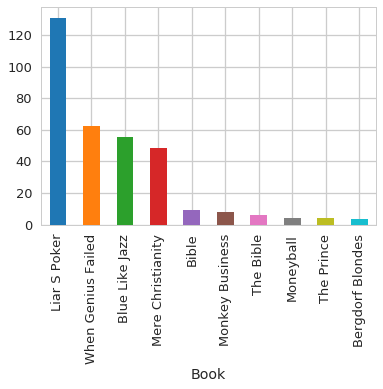

In [88]:
conservative_books.lift_conservative.plot(kind='bar')

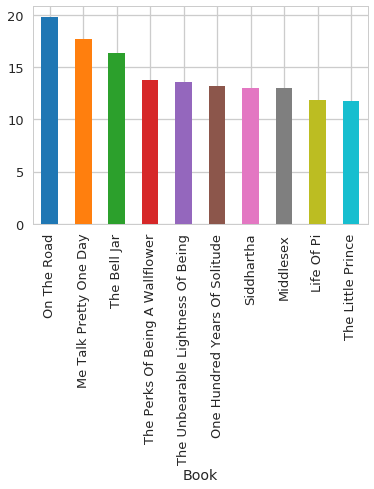

In [89]:
liberal_books.lift_liberal.plot(kind='bar')

#### Exercise

We have seen how to compute the log-odds between liberal-conservative for each book. Given this information, we can try to estimate political leanings of students. You can do this by summing the log-odds of their favorite books. 

Steps: 
1. Create a table with the log-odds of the books. 
2. Join the table with the log-odds with the book preferences table.
3. Sum the log-odds score for each student.

Evaluation:
* You have students that have declared their political preferences as Liberal, Conservative, Very Liberal, Very Conservative. Examine the scores for these students, to check how well this technique works. The simplest way is to compute the average (mean) log-odds for students that fall into the different groups. Alternatively, you can try to plot the full distribution of scores.
* Calculate a score for all students that did not declare a political view. 

Notes: 
* You can do the work in MySQL or in Pandas. If you decide to work purely in Pandas, the [`merge`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html#pandas.DataFrame.merge) command allows you to perform joins between dataframes, in way similar to SQL.

### Inserting Data in a Database using Pandas

In [ ]:
# Read the CSV file
restaurants = pd.read_csv('data/restaurant.csv.gz', encoding="utf-8", dtype="unicode")

In [ ]:
# Usual bookkeeping regarding datatypes
restaurants["GRADE DATE"] = pd.to_datetime(restaurants["GRADE DATE"], format="%m/%d/%Y")
restaurants["RECORD DATE"] = pd.to_datetime(restaurants["RECORD DATE"], format="%m/%d/%Y")
restaurants["INSPECTION DATE"] = pd.to_datetime(restaurants["INSPECTION DATE"], format="%m/%d/%Y")
restaurants["SCORE"] = pd.to_numeric(restaurants["SCORE"])
restaurants["BORO"] =  pd.Categorical(restaurants["BORO"], ordered=False)
restaurants["GRADE"] =  pd.Categorical(restaurants["GRADE"], categories = ['A', 'B', 'C'], ordered=True)
restaurants["VIOLATION CODE"] =  pd.Categorical(restaurants["VIOLATION CODE"], ordered=False)
restaurants["CRITICAL FLAG"] =  pd.Categorical(restaurants["CRITICAL FLAG"], ordered=False)
restaurants["ACTION"] =  pd.Categorical(restaurants["ACTION"], ordered=False)
restaurants["CUISINE DESCRIPTION"] =  pd.Categorical(restaurants["CUISINE DESCRIPTION"], ordered=False)

In [ ]:
# Connect to the MySQL, but without selecting a database
conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    encoding='utf-8'
)
engine = create_engine(conn_string)

In [ ]:
# Create the database where we want to store the data
# Do not worry about the Warning if the database already exists
engine.execute('CREATE DATABASE IF NOT EXISTS nyc_restaurant_inspections')
engine.execute('USE nyc_restaurant_inspections')

In [ ]:
# We drop the table if it is already there
engine.execute('DROP TABLE IF EXISTS inspections')
# Store the dataframe as a SQL table, using the to_sql command
restaurants.to_sql(name='inspections', # name the table "inspections"
                   con=engine, # use the connection to MySQL created earlier
                   if_exists='replace', # if the table is already there, replace it
                   index=False, # do not write the index column in the database
                   chunksize=1000 # write 1000 lines at a time)
                  )

In [ ]:
# And then we can just retrieve it from the database
df = pd.read_sql("SELECT * FROM inspections LIMIT 100", con=engine)
df.head(100)